In [1]:
import pandas as pd
import seaborn as sns
import keras
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import math
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
# read CSV file
data = pd.read_csv(r'propulsion.csv')

In [3]:
# delete id column 
data.drop(['Unnamed: 0'],axis=1,inplace=True)
data.head()

,Lever position (lp) [ ],Ship speed (v) [knots],Gas Turbine shaft torque (GTT) [kN m],Gas Turbine rate of revolutions (GTn) [rpm],Gas Generator rate of revolutions (GGn) [rpm],Starboard Propeller Torque (Ts) [kN],Port Propeller Torque (Tp) [kN],HP Turbine exit temperature (T48) [C],GT Compressor inlet air temperature (T1) [C],GT Compressor outlet air temperature (T2) [C],HP Turbine exit pressure (P48) [bar],GT Compressor inlet air pressure (P1) [bar],GT Compressor outlet air pressure (P2) [bar],Gas Turbine exhaust gas pressure (Pexh) [bar],Turbine Injecton Control (TIC) [%],Fuel flow (mf) [kg/s],GT Compressor decay state coefficient.,GT Turbine decay state coefficient.
0,9.300,27.0,72762.205,3560.393,9753.812,644.806,644.806,1086.583,288.0,780.304,4.523,0.998,22.879,1.050,90.435,1.790,0.973,0.978
1,6.175,18.0,29760.552,2306.825,8780.012,246.011,246.011,776.921,288.0,665.511,2.518,0.998,13.438,1.030,34.596,0.685,0.995,0.975
2,3.144,9.0,8375.774,1386.739,7051.621,60.318,60.318,589.764,288.0,580.587,1.392,0.998,7.566,1.020,12.477,0.247,0.980,0.978
3,3.144,9.0,8377.589,1386.748,7098.469,60.339,60.339,570.651,288.0,576.565,1.390,0.998,7.409,1.021,11.678,0.231,0.984,1.000
4,6.175,18.0,29761.091,2306.825,8782.024,246.021,246.021,769.855,288.0,663.682,2.518,0.998,13.374,1.031,34.154,0.676,0.998,0.980


In [4]:
# check if CSV file contains NULL values
data.isnull().sum()

### as file not contains NULL values we can skip data cleaning process

Lever position (lp) [ ]                          0
Ship speed (v) [knots]                           0
Gas Turbine shaft torque (GTT) [kN m]            0
Gas Turbine rate of revolutions (GTn) [rpm]      0
Gas Generator rate of revolutions (GGn) [rpm]    0
Starboard Propeller Torque (Ts) [kN]             0
Port Propeller Torque (Tp) [kN]                  0
HP Turbine exit temperature (T48) [C]            0
GT Compressor inlet air temperature (T1) [C]     0
GT Compressor outlet air temperature (T2) [C]    0
HP Turbine exit pressure (P48) [bar]             0
GT Compressor inlet air pressure (P1) [bar]      0
GT Compressor outlet air pressure (P2) [bar]     0
Gas Turbine exhaust gas pressure (Pexh) [bar]    0
Turbine Injecton Control (TIC) [%]               0
Fuel flow (mf) [kg/s]                            0
GT Compressor decay state coefficient.           0
GT Turbine decay state coefficient.              0
dtype: int64

In [5]:
Y_c = data['GT Compressor decay state coefficient.']
Y_t = data['GT Turbine decay state coefficient.']

# delete 'GT Compressor decay state coefficient.' and 'GT Turbine decay state coefficient.'
# as we don't need in training features
data.drop(['GT Compressor decay state coefficient.', 'GT Turbine decay state coefficient.'],axis=1,inplace=True)
X = data

# scale values in [0,1] for training and testing
scaler = StandardScaler()
X = scaler.fit_transform(X)

# delete CSV data as we don't that in future
del data

# split data in Testing and Training set
size = 9000
X_train, X_test ,Y_c_train, Y_c_test, Y_t_train, Y_t_test = \
    X[:size] ,X[size:] ,Y_c[:size] ,Y_c[size:] ,Y_t[:size] , Y_t[size:]

In [6]:
# define general function for ploting predicted and true points
def plot(y,y_pred,size=100):
    # plot Predicted vs true values
    plt.figure(figsize=(20,7))
    plt.plot(range(size),y_pred.reshape(-1)[:size],label="prediction")
    plt.plot(range(size),y[:size],label='actual')
    plt.legend()

# for predicting 'GT Compressor decay state coefficient.'

## Simple Neural Network Model with 2 hidden layers

In [7]:
# define NN model
nn_model = Sequential()
nn_model.add(Dense(300, input_shape= (16,)))
nn_model.add(Dense(100, activation='relu'))
nn_model.add(Dense(100, activation='relu'))
nn_model.add(Dense(1, activation='relu'))

# loss function MSE
# Optimizer Adam with default learning rate .001
nn_model.compile(loss='mean_squared_error', optimizer='adam')

In [8]:
# print model description
print(nn_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               5100      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 45,401
Trainable params: 45,401
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
# define early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                            patience=3,restore_best_weights=True)

# train model
history = nn_model.fit(X_train, Y_c_train, epochs=200, 
                    validation_data=(X_test,Y_c_test), 
                    batch_size=1000,callbacks=[callback],verbose=0)

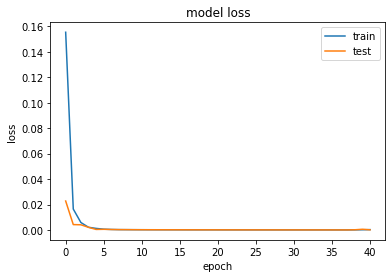

In [10]:
# plot model loss vs epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

In [11]:
# calculate MSE, MAE and RMSE errors on train set
nn_mse = mean_squared_error(Y_c_train, nn_model.predict(X_train))
nn_mae = mean_absolute_error(Y_c_train, nn_model.predict(X_train))
print("Neural Network train  mse = ",nn_mse,"  mae = ",nn_mae,"  rmse = ", math.sqrt(nn_mse))

# calculate MSE, MAE and RMSE errors on test set
nn_test_mse = mean_squared_error(Y_c_test, nn_model.predict(X_test))
nn_test_mae = mean_absolute_error(Y_c_test, nn_model.predict(X_test))
print("Neural Network test   mse = ",nn_test_mse,"  mae = ",nn_test_mae,"  rmse = ", math.sqrt(nn_test_mse))

Neural Network train  mse =  5.336838337959551e-05   mae =  0.005750192960156336   rmse =  0.007305366751888334
Neural Network test   mse =  5.292202236603748e-05   mae =  0.005694816712379456   rmse =  0.007274752392077512


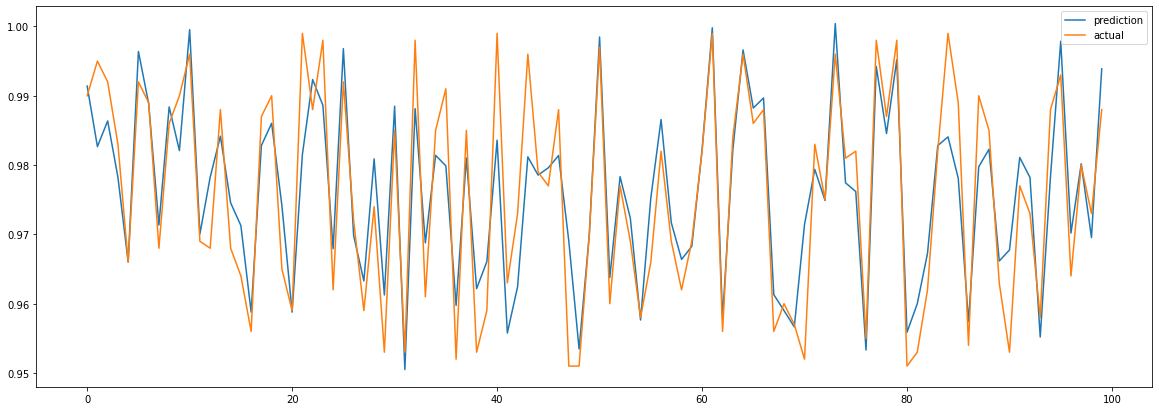

In [12]:
# predict on test set for evaluation
y_pred = nn_model.predict(X_test)
plot(Y_c_test, y_pred)

## Linear Regression Model

In [13]:
# define Linear Regression model
lr_model = LinearRegression()

# train model on train set
lr_model.fit(X_train, Y_c_train)

LinearRegression()

In [14]:
# calculate MSE, MAE and RMSE error in train set
lr_mse = mean_squared_error(Y_c_train, lr_model.predict(X_train))
lr_mae = mean_absolute_error(Y_c_train, lr_model.predict(X_train))
print("Linear Regression train  mse = ",lr_mse,"  mae = ",lr_mae,"  rmse = ", math.sqrt(lr_mse))

# calculate MSE, MAE and RMSE errors on test set
lr_test_mse = mean_squared_error(Y_c_test, lr_model.predict(X_test))
lr_test_mae = mean_absolute_error(Y_c_test, lr_model.predict(X_test))
print("Linear Regression test   mse = ",lr_test_mse,"  mae = ",lr_test_mae,"  rmse = ", math.sqrt(lr_test_mse))

Linear Regression train  mse =  3.432519863693234e-05   mae =  0.004602118790527994   rmse =  0.005858771085896115
Linear Regression test   mse =  3.244838515451379e-05   mae =  0.004429553266492561   rmse =  0.005696348405295606


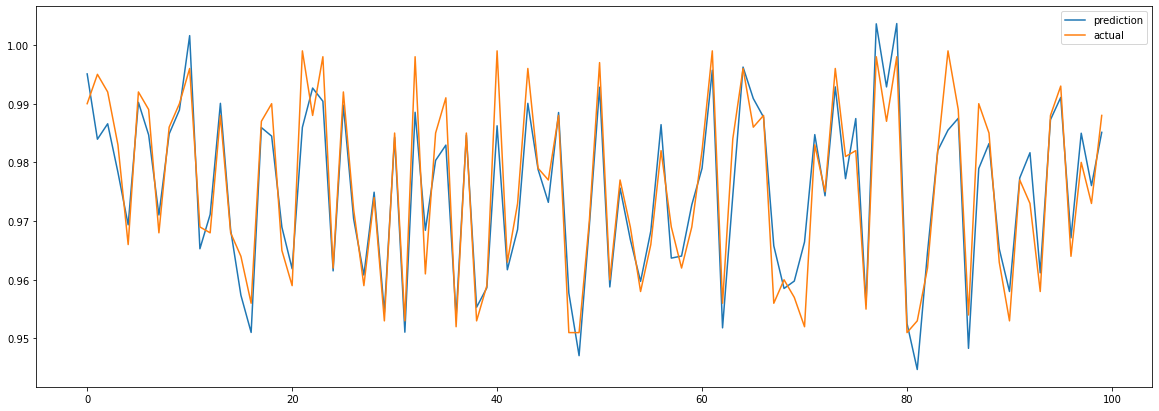

In [15]:
plot(Y_c_test,lr_model.predict(X_test))

## Decision Tree Regressor Model

In [16]:
# define Decision Tree Regressor Model
tree_model = DecisionTreeRegressor()

In [17]:
# train Decision Tree Regressor Model
tree_model.fit(X_train, Y_c_train)

DecisionTreeRegressor()

In [18]:
# calculate MSE, MAE and RMSE errors on train set
tree_mse = mean_squared_error(Y_c_train, tree_model.predict(X_train))
tree_mae = mean_absolute_error(Y_c_train, tree_model.predict(X_train))
print("Decision Tree train  mse = ",tree_mse,"  mae = ",tree_mae,"  rmse = ", math.sqrt(tree_mse))

# calculate MSE, MAE and RMSE errors on test set
tree_test_mse = mean_squared_error(Y_c_test, tree_model.predict(X_test))
tree_test_mae = mean_absolute_error(Y_c_test, tree_model.predict(X_test))
print("Decision Tree test   mse = ",tree_test_mse,"  mae = ",tree_test_mae,"  rmse = ", math.sqrt(tree_test_mse))

Decision Tree train  mse =  6.971010429817621e-34   mae =  6.278927994824496e-18   rmse =  2.6402671133462276e-17
Decision Tree test   mse =  3.0010000000000052e-06   mae =  0.0010470000000000024   rmse =  0.001732339458651221


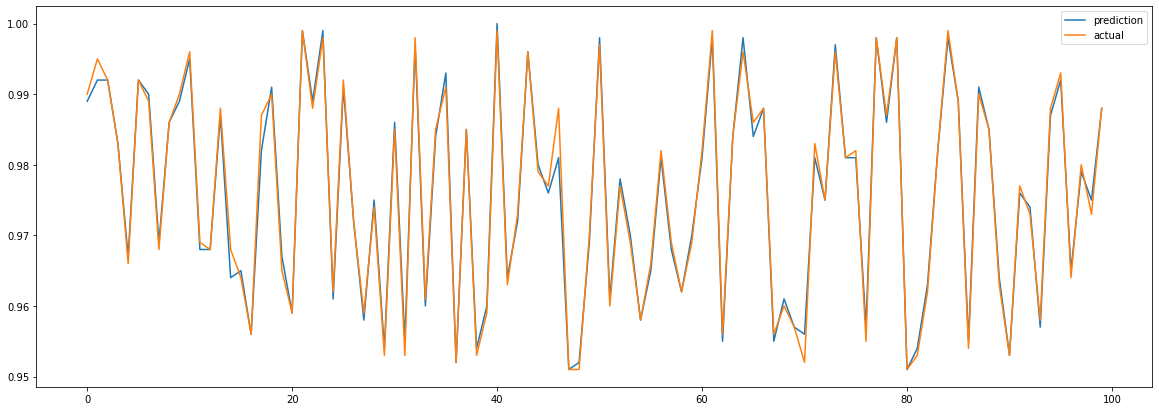

In [19]:
plot(Y_c_test,tree_model.predict(X_test))

## Random Forest Regressor Model

In [20]:
# define Random Forest Regressor Model
rf_model = RandomForestRegressor()

In [21]:
# train Random Forest Regressor Model
rf_model.fit(X_train, Y_c_train)

RandomForestRegressor()

In [22]:
# calculate MSE, MAE and RMSE errors on train set
rf_mse = mean_squared_error(Y_c_train, rf_model.predict(X_train))
rf_mae = mean_absolute_error(Y_c_train, rf_model.predict(X_train))
print("Random Forest train  mse = ",rf_mse,"  mae = ",rf_mae,"  rmse = ", math.sqrt(rf_mse))

# calculate MSE, MAE and RMSE errors on test set
rf_test_mse = mean_squared_error(Y_c_test, rf_model.predict(X_test))
rf_test_mae = mean_absolute_error(Y_c_test, rf_model.predict(X_test))
print("Random Forest test   mse = ",rf_test_mse,"  mae = ",rf_test_mae,"  rmse = ", math.sqrt(rf_test_mse))

Random Forest train  mse =  1.429964222222218e-07   mae =  0.00019572444444446657   rmse =  0.0003781486774037717
Random Forest test   mse =  1.2275128999999889e-06   mae =  0.0005389899999999704   rmse =  0.0011079318119812198


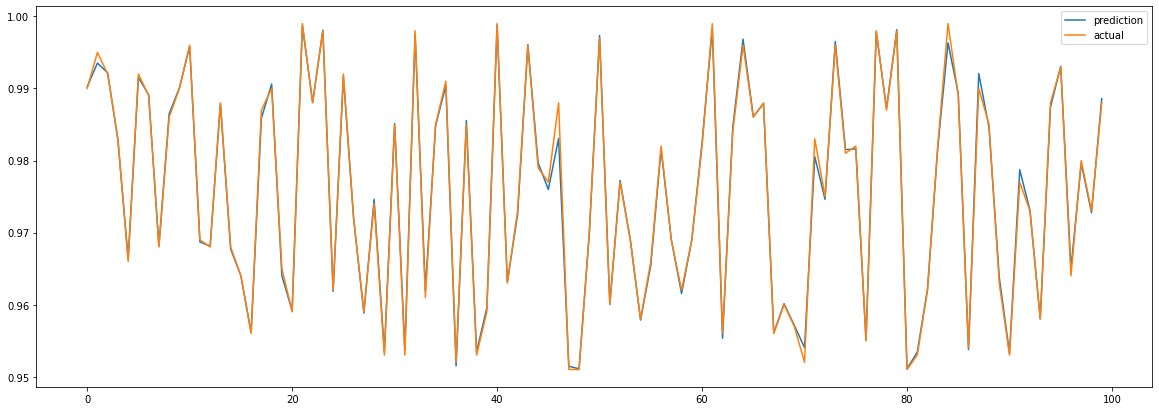

In [23]:
plot(Y_c_test,rf_model.predict(X_test))

# compare results of all 4 Models

In [24]:
print("Neural Network train     mse = ",nn_mse,"  mae = ",nn_mae,"  rmse = ", math.sqrt(nn_mse))
print("Neural Network test      mse = ",nn_test_mse,"  mae = ",nn_test_mae,"  rmse = ", math.sqrt(nn_test_mse))

print("Linear Regression train  mse = ",lr_mse,"  mae = ",lr_mae,"  rmse = ", math.sqrt(lr_mse))
print("Linear Regression test   mse = ",lr_test_mse,"  mae = ",lr_test_mae,"  rmse = ", math.sqrt(lr_test_mse))

print("Decision Tree train      mse = ",tree_mse,"  mae = ",tree_mae,"  rmse = ", math.sqrt(tree_mse))
print("Decision Tree test       mse = ",tree_test_mse,"  mae = ",tree_test_mae,"  rmse = ", math.sqrt(tree_test_mse))

print("Random Forest train      mse = ",rf_mse,"  mae = ",rf_mae,"  rmse = ", math.sqrt(rf_mse))
print("Random Forest test       mse = ",rf_test_mse,"  mae = ",rf_test_mae,"  rmse = ", math.sqrt(rf_test_mse))

Neural Network train     mse =  5.336838337959551e-05   mae =  0.005750192960156336   rmse =  0.007305366751888334
Neural Network test      mse =  5.292202236603748e-05   mae =  0.005694816712379456   rmse =  0.007274752392077512
Linear Regression train  mse =  3.432519863693234e-05   mae =  0.004602118790527994   rmse =  0.005858771085896115
Linear Regression test   mse =  3.244838515451379e-05   mae =  0.004429553266492561   rmse =  0.005696348405295606
Decision Tree train      mse =  6.971010429817621e-34   mae =  6.278927994824496e-18   rmse =  2.6402671133462276e-17
Decision Tree test       mse =  3.0010000000000052e-06   mae =  0.0010470000000000024   rmse =  0.001732339458651221
Random Forest train      mse =  1.429964222222218e-07   mae =  0.00019572444444446657   rmse =  0.0003781486774037717
Random Forest test       mse =  1.2275128999999889e-06   mae =  0.0005389899999999704   rmse =  0.0011079318119812198


In [ ]:
# save best model for further use
model_name = 'model_GT_Compressor_decay_state_coefficient.pkl'

# Create an variable to pickle and open it in write mode
with open(model_name, 'wb') as f:
    pickle.dump([rf_model,scaler],f)